# OPTIMIZACIÓN Y PRIORIZACIÓN  DE ATENCIÓN DE FALLAS EN PALAS MINERAS MEDIANTE ML Y LLM

Eduardo Jopia Fernandez

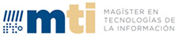


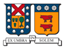

# **Prueba 1. Model A RAG — Consultas al manual 4100XPC**

2.3 Modelos de lenguaje de gran escala (LLM)

En paralelo a los avances del aprendizaje automático, los Modelos de Lenguaje de Gran Escala (LLM), como GPT-4, han revolucionado la forma en que las organizaciones gestionan y acceden a su conocimiento operativo. Estos modelos, entrenados con billones de parámetros, son capaces de comprender y generar lenguaje natural con un alto grado de coherencia, permitiendo su aplicación como sistemas de apoyo cognitivo a la toma de decisiones.

En  mantenimiento, el conocimiento técnico está disperso en manuales, reportes de fallas, hojas de datos y experiencias de campo. Tradicionalmente, acceder a esta información ha requerido la intervención humana, con procesos lentos y dependientes de la memoria organizacional. Los LLM permiten centralizar este conocimiento en una interfaz conversacional, donde el usuario puede consultar en lenguaje natural y obtener respuestas fundamentadas en documentos técnicos o históricos.

Una de las técnicas más efectivas para aplicar LLM en entornos industriales es el enfoque Retrieval-Augmented Generation (RAG). Este método combina la recuperación semántica de información con la generación contextual de respuestas, lo que significa que el modelo no responde basándose solo en su entrenamiento previo, sino que consulta primero una base de datos documental actualizada antes de generar la respuesta final. Así, se mitigan los problemas de alucinación y se garantiza que las recomendaciones estén sustentadas en evidencia verificable. Aplicado al mantenimiento minero, un modelo RAG puede, por ejemplo, acceder a manuales de fabricante, reportes de intervenciones previas y datos de confiabilidad, para explicar las posibles causas de una alerta técnica o sugerir pasos de diagnóstico. De esta manera, el LLM actúa como un agente inteligente que asiste al personal en la resolución de problemas complejos, reduciendo la dependencia exclusiva de la experiencia humana.

 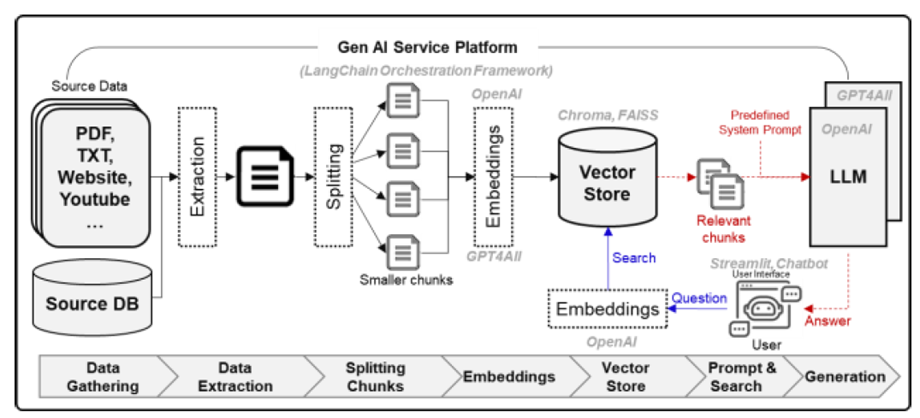

Figura N°2. Flujo de implementación de un servicio de IA generativa basado en RAG.

El análisis del marco teórico demuestra que los Modelos de Lenguaje de Gran Escala (LLM), combinados con técnicas avanzadas de Retrieval Augmented Generation (RAG), representan una evolución significativa en los sistemas de apoyo a la decisión basados en conocimiento. A diferencia de los enfoques tradicionales de recuperación de información o predicción estadística, los modelos RAG integran la generación contextual con la recuperación documental, permitiendo respuestas más precisas, verificables y alineadas con la evidencia técnica disponible.

La revisión de la literatura reciente evidencia que los RAG avanzados, complementados con estructuras de grafos o agentes cognitivos, mejoran la coherencia semántica y reducen el riesgo de alucinaciones, fortaleciendo su aplicabilidad en entornos industriales complejos como el mantenimiento minero. Este enfoque híbrido facilita la construcción de sistemas inteligentes capaces de razonar sobre datos técnicos, explicar decisiones y aprender continuamente a partir de la retroalimentación operativa, transformando el conocimiento documental en acciones operativas concretas. Este marco conceptual constituye la base del desarrollo experimental presentado en el capítulo siguiente, donde se detallan los modelos implementados, los procesos de entrenamiento y la validación de la solución propuesta


In [8]:
# === Interfaz solo para consultas No-RAG ===
!pip -q install gradio>=4.41.0
!pip -q install -U "openai>=1.43.0" "langchain-openai>=0.1.22" python-dotenv>=1.0.1

import gradio as gr
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from google.colab import drive
from pathlib import Path
from dotenv import load_dotenv
import os

# --- Montar Drive y cargar .env ---
drive.mount('/content/drive', force_remount=True)
ENV_PATH = "/content/drive/MyDrive/RAG/env/.env"   # <-- ajusta si difiere
assert Path(ENV_PATH).is_file(), f"No se encontró .env en {ENV_PATH}"
load_dotenv(ENV_PATH, override=True)
assert os.getenv("OPENAI_API_KEY"), "Falta OPENAI_API_KEY en el entorno."


# Define the LLM here
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

MAX_Q = 2000

def no_rag_answer(question: str) -> str:
    q = (question or "").strip()
    if not q:
        return "Ingresa una pregunta."
    if len(q) > MAX_Q:
        return f"Tu pregunta excede {MAX_Q} caracteres. Acórtala."

    messages = [
        SystemMessage(content=(
            "Responde SIEMPRE en español neutro, técnico y conciso. "
            "Evita inventar datos; si no estás seguro, dilo explícitamente."
        )),
        HumanMessage(content=f"Pregunta: {q}\n\nRespuesta concisa:")
    ]
    try:
        return llm.invoke(messages).content
    except Exception as e:
        return f"Error al invocar el LLM: {type(e).__name__}: {e}"

with gr.Blocks(title="Modelo A — LLM sin RAG", theme="soft") as demo_no_rag:
    gr.Markdown("## Modelo B — Consultas **sin RAG**\nEl modelo responde sin consultar documentos externos.")
    q = gr.Textbox(label="Pregunta", placeholder="Ej: Explica qué es un sistema RAG en 3 líneas.", lines=2)
    btn = gr.Button("Consultar", variant="primary")
    ans = gr.Markdown(label="Respuesta")

    btn.click(no_rag_answer, inputs=[q], outputs=[ans])

demo_no_rag.queue().launch(share=False)

Mounted at /content/drive
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [9]:
# ===========================================
# RAG 4100XPC — Setup + Ingesta/Load + UI (FAISS)
# ===========================================
!pip -q install -U "openai>=1.43.0" "langchain-openai>=0.1.22" \
                  "langchain-community>=0.2.16" "pypdf>=4.3.1,<5" \
                  "faiss-cpu>=1.8.0" "gradio>=4.41.0" "python-dotenv>=1.0.1"

from google.colab import drive
from pathlib import Path
from dotenv import load_dotenv
import os, hashlib, gradio as gr

from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_core.messages import SystemMessage, HumanMessage

# --- Montar Drive y cargar .env ---
drive.mount('/content/drive', force_remount=True)
ENV_PATH = "/content/drive/MyDrive/RAG/env/.env"   # <-- ajusta si difiere
assert Path(ENV_PATH).is_file(), f"No se encontró .env en {ENV_PATH}"
load_dotenv(ENV_PATH, override=True)
assert os.getenv("OPENAI_API_KEY"), "Falta OPENAI_API_KEY en el entorno."

# --- Paths / parámetros ---
PDF_PATH   = "/content/drive/MyDrive/RAG/data/raw/4100XPC_manual.pdf"
INDEX_DIR  = "/content/drive/MyDrive/RAG/index/4100XPC_FAISS"
EMB_MODEL  = "text-embedding-3-small"
CHUNK_SIZE, CHUNK_OVERLAP = 800, 120
MAX_Q = 2000

# --- LLM base ---
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, max_retries=3, timeout=60)

# --- Cargar índice si existe; si no, ingestar y crearlo ---
emb = OpenAIEmbeddings(model=EMB_MODEL)
if Path(INDEX_DIR).is_dir() and list(Path(INDEX_DIR).glob("*")):
    vs = FAISS.load_local(INDEX_DIR, emb, allow_dangerous_deserialization=True)
else:
    assert Path(PDF_PATH).is_file(), f"No se encontró el PDF: {PDF_PATH}"
    loader = PyPDFLoader(PDF_PATH)
    docs = loader.load()
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP, add_start_index=True
    )
    chunks = splitter.split_documents(docs)
    def chunk_id(d):
        src=d.metadata.get("source",""); page=str(d.metadata.get("page",""))
        start=str(d.metadata.get("start_index","")); head=(d.page_content or "")[:64]
        return hashlib.md5(f"{src}|{page}|{start}|{head}".encode("utf-8")).hexdigest()
    for d in chunks: d.metadata["uid"] = chunk_id(d)
    vs = FAISS.from_documents(chunks, emb)
    Path(INDEX_DIR).mkdir(parents=True, exist_ok=True)
    vs.save_local(INDEX_DIR)

# --- Utilidades ---
def _safe_base(p):
    try: return os.path.basename(p) if isinstance(p,str) else "?"
    except: return "?"
def _format_ctx(docs):
    if not docs: return ""
    out=[]
    for d in docs:
        src=_safe_base(d.metadata.get("source","?"))
        page=d.metadata.get("page","?")
        txt=(d.page_content or "").strip().replace("\n"," ")
        out.append(f"[p.{page}] {txt[:1200]} (fuente: {src})")
    return "\n\n".join(out)
def _format_sources(docs):
    if not docs: return "_(sin fuentes)_"
    return "\n".join([f"- **{_safe_base(d.metadata.get('source','?'))}** [p.{d.metadata.get('page','?')}]" for d in docs])

# --- Función RAG (usa vs.similarity_search para respetar K del slider) ---
def rag_answer(question: str, k: int, ver_chunks: bool):
    q = (question or "").strip()
    if not q:
        return "Ingresa una pregunta.", "", ""
    if len(q) > MAX_Q:
        return f"Tu pregunta excede {MAX_Q} caracteres.", "", ""

    k = max(1, int(k))
    try:
        docs = vs.similarity_search(q, k=k)
    except Exception as e:
        return f"Error al recuperar documentos: {type(e).__name__}: {e}", "", ""

    if not docs:
        return "No hay evidencia en las fuentes", "_(sin fuentes)_", ""

    context = _format_ctx(docs)
    messages = [
        SystemMessage(content=(
            "Responde SIEMPRE en español neutro, técnico y conciso. "
            "Responde SOLO con información del CONTEXTO. "
            "Si algo no está en el contexto, responde exactamente: 'No hay evidencia en las fuentes'. "
            "Incluye citas [p.X] donde corresponda."
        )),
        HumanMessage(content=f"Pregunta: {q}\n\nContexto:\n{context}\n\nRespuesta concisa y citada:")
    ]
    try:
        answer = llm.invoke(messages).content
    except Exception as e:
        answer = f"Error al invocar el LLM: {type(e).__name__}: {e}"

    fuentes = _format_sources(docs)
    chunks = ""
    if ver_chunks:
        parts=[]
        for i,d in enumerate(docs):
            parts.append(f"**Chunk {i+1} — p.{d.metadata.get('page','?')} — {_safe_base(d.metadata.get('source','?'))}**\n\n{(d.page_content or '')[:1200]}")
        chunks = "\n\n".join(parts)

    return answer, fuentes, chunks

# --- UI Gradio ---
with gr.Blocks(title="Modelo B Con RAG — 4100XPC", theme="soft") as demo:
    gr.Markdown("## Modelo B Con RAG — Consultas al manual 4100XPC\nEl modelo responde **solo** con el contexto recuperado.")
    with gr.Row():
        q = gr.Textbox(label="Pregunta", lines=2, placeholder="Ej: lubricación correcta")
    with gr.Row():
        k = gr.Slider(1, 12, value=6, step=1, label="Top-K (número de chunks)")
        ver_chunks = gr.Checkbox(False, label="Mostrar chunks recuperados")
    btn = gr.Button("Consultar", variant="primary")
    ans = gr.Markdown(label="Respuesta (con citas [p.X])")
    src = gr.Markdown(label="Fuentes")
    chn = gr.Markdown(label="Chunks recuperados (opcional)")
    btn.click(rag_answer, inputs=[q, k, ver_chunks], outputs=[ans, src, chn])

demo.queue().launch(share=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
Mounted at /content/drive
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab note

<IPython.core.display.Javascript object>

In [10]:
# === UI COMPARADOR: No-RAG vs RAG (FAISS-ready) ===
!pip -q install gradio>=4.41.0
import gradio as gr
import os, time

# ---- Validaciones mínimas del entorno ----
try:
    llm
except NameError:
    raise RuntimeError("Falta 'llm'. Define antes: llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)")
if "vs" not in globals():
    raise RuntimeError("Falta 'vs'. Carga/crea el índice y define vs antes de la UI.")

# Define the retriever from the vector store
retriever = vs.as_retriever()

# ---- Utilidades ----
def format_ctx(docs):
    blocks = []
    for d in docs:
        src = os.path.basename(d.metadata.get("source", "?"))
        page = d.metadata.get("page", "?")
        txt  = (d.page_content or "").strip().replace("\n", " ")
        blocks.append(f"[p.{page}] {txt[:1200]} (fuente: {src})")
    return "\n\n".join(blocks)

def build_prompt(question: str, context: str | None = None) -> str:
    system = (
        "Responde SIEMPRE en español neutro, técnico y conciso. " +
        (
            "Responde SOLO con información del CONTEXTO. "
            "Si algo no está en el contexto, responde exactamente: 'No hay evidencia en las fuentes'. "
            "Incluye citas [p.X] donde corresponda."
            if context else
            "Evita inventar datos; si no estás seguro, dilo explícitamente."
        )
    )
    user = (
        f"Pregunta: {question}\n\nContexto:\n{context}\n\nRespuesta concisa y citada:"
        if context else
        f"Pregunta: {question}\n\nRespuesta concisa:"
    )
    return f"<|system|>\n{system}\n<|user|>\n{user}\n<|assistant|>\n"

# ---- Backends ----
def ask_no_rag(question: str) -> str:
    prompt = build_prompt(question, context=None)
    return llm.invoke(prompt).content

def rag_backend(question: str, k: int):
    """Devuelve (respuesta, fuentes_md, chunks_md) usando vs (FAISS) o retriever."""
    q = (question or "").strip()
    k = max(1, int(k))

    # Recuperación con score (FAISS) si está 'vs'; fallback a retriever
    docs, scores = [], []
    used_scores = False
    if vs is not None:
        try:
            # FAISS soporta similarity_search_with_score
            results = vs.similarity_search_with_score(q, k=k)
            docs   = [d for d, _ in results]
            scores = [float(s) for _, s in results]
            used_scores = True
        except Exception:
            pass
    if not docs:
        docs = retriever.get_relevant_documents(q)
        scores = [None] * len(docs)

    context = format_ctx(docs)
    prompt  = build_prompt(q, context=context)
    answer  = llm.invoke(prompt).content

    # Fuentes
    lines = []
    for i, d in enumerate(docs):
        src = os.path.basename(d.metadata.get("source", "?"))
        page = d.metadata.get("page", "?")
        sc = scores[i]
        lines.append(f"- **{src}** [p.{page}]" if sc is None else f"- **{src}** [p.{page}] — score: {sc:.3f}")
    fuentes_md = "\n".join(lines) if lines else "_(sin fuentes)_"

    # Chunks (auditoría)
    chunks_md = "\n\n".join(
        [f"**Chunk {i+1} — p.{d.metadata.get('page','?')} — {os.path.basename(d.metadata.get('source','?'))}**\n\n{(d.page_content or '')[:1200]}"
         for i, d in enumerate(docs)]
    )
    return answer, fuentes_md, chunks_md

# ---- Orquestador para la UI ----
def compare_answer(question: str, k: int, show_chunks: bool, mode: str):
    q = (question or "").strip()
    if not q:
        return "Ingresa una pregunta.", "", "—", "—"

    ans_no = ans_rag = "—"
    fuentes_md = "—"
    chunks_md  = "—"

    if mode in ("No-RAG", "Ambos"):
        t0 = time.time()
        try:
            ans_no = ask_no_rag(q)
        except Exception as e:
            ans_no = f"Error No-RAG: {type(e).__name__}: {e}"
        ans_no = f"** {time.time()-t0:.2f}s**\n\n" + ans_no

    if mode in ("RAG", "Ambos"):
        t0 = time.time()
        try:
            ans_rag, fuentes_md, chunks_md = rag_backend(q, k=k)
        except Exception as e:
            ans_rag, fuentes_md, chunks_md = f"Error RAG: {type(e).__name__}: {e}", "—", "—"
        ans_rag = f"** {time.time()-t0:.2f}s**\n\n" + ans_rag
        if not show_chunks:
            chunks_md = "—"

    return ans_no, ans_rag, fuentes_md, chunks_md

# ---- UI Gradio ----
with gr.Blocks(title="Comparador — No-RAG vs RAG") as app:
    gr.Markdown("##  Comparador No-RAG vs RAG (4100XPC)\nMisma pregunta; compara salidas. En RAG se citan páginas [p.X].")
    with gr.Row():
        mode = gr.Radio(choices=["No-RAG", "RAG", "Ambos"], value="Ambos", label="Modo")
        k = gr.Slider(1, 12, value=6, step=1, label="Top-K (solo RAG)")
        show_chunks = gr.Checkbox(False, label="Mostrar chunks (solo RAG)")
    q = gr.Textbox(label="Pregunta", placeholder="Ej: ¿Cuál es el correcto procedimiento de arranque de la 4100XPC?")

    btn = gr.Button("Consultar", variant="primary")

    gr.Markdown("###  Resultados de la consulta")
    gr.Markdown("####  Respuesta — No-RAG")
    ans_no = gr.Markdown()

    gr.Markdown("---")
    gr.Markdown("####  Respuesta — RAG")
    ans_rg = gr.Markdown()

    gr.Markdown("####  Fuentes utilizadas en RAG")
    src = gr.Markdown()

    gr.Markdown("####  Chunks recuperados (opcional)")
    chn = gr.Markdown()

    btn.click(compare_answer, inputs=[q, k, show_chunks, mode], outputs=[ans_no, ans_rg, src, chn])

app.launch(share=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>